In [1]:
from bs4 import BeautifulSoup
import requests
from invest import *

import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa import arima_model
import statsmodels.tsa.stattools as ts
from itertools import product
from pylab import plt, mpl
from scipy.stats import linregress
from scipy.stats import pearsonr
from datetime import datetime
import math

In [2]:
#Oil and gas stocks crwaling


url = "https://finance.yahoo.com/u/yahoo-finance/watchlists/oil-and-gas-stocks/"
res = requests.get(url)
res.raise_for_status()
soup = BeautifulSoup(res.text,"lxml")

In [3]:
data_rows = soup.find_all("section", attrs={"class":"Mb(30px)", "data-test":"cwl-symbols"})
data_rows
for row in data_rows:
    columns = row.find_all('a', attrs={"class":"Fw(b)"})
    if len(columns) <= 1:
        continue
    data = [column.get_text().strip() for column in columns]
    print(data)


['XOM', 'CVX', 'RDS-A', 'RDS-B', 'TOT', 'PTR', 'BP', 'ENB', 'COP', 'OGZPY', 'EQNR', 'PBR-A', 'PBR', 'EPD', 'TRP', 'EOG', 'SLB', 'E', 'PXD', 'CNQ', 'KMI', 'MPC', 'PSX', 'SU', 'VLO', 'WMB', 'MPLX', 'ET', 'BKR', 'OXY']


In [4]:
start_date = '2018-11-01'
end_date = '2021-05-01'

#download stock data from yahoo
df = pdr.get_data_yahoo(data, start_date, end_date)['Close']
df.tail()

Symbols,XOM,CVX,RDS-A,RDS-B,TOT,PTR,BP,ENB,COP,OGZPY,...,KMI,MPC,PSX,SU,VLO,WMB,MPLX,ET,BKR,OXY
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-26,55.680000,101.519997,38.310001,36.299999,44.529999,35.130001,24.920000,37.180000,50.250000,6.17,...,16.910000,53.270000,76.500000,20.540001,70.519997,23.969999,26.709999,8.18,20.139999,24.900000
2021-04-27,56.410000,102.699997,38.520000,36.410000,44.709999,35.090000,24.940001,37.669998,51.299999,6.17,...,17.000000,53.889999,78.099998,20.860001,71.820000,23.940001,26.559999,8.41,19.920000,25.090000
2021-04-28,58.110001,105.220001,39.080002,36.919998,45.869999,35.779999,25.639999,38.150002,53.040001,6.22,...,17.440001,55.439999,80.099998,21.570000,74.120003,24.430000,27.230000,8.60,20.250000,26.100000
2021-04-29,58.939999,106.900002,38.650002,36.400002,45.189999,37.279999,25.500000,38.570000,53.130001,6.14,...,17.290001,56.040001,81.120003,21.760000,74.860001,24.580000,27.530001,8.84,20.540001,25.940001
2021-04-30,57.240002,103.070000,38.000000,35.810001,44.279999,36.029999,25.160000,38.570000,51.139999,6.09,...,17.049999,55.650002,80.910004,21.420000,73.959999,24.360001,26.990000,8.61,20.080000,25.360001


In [7]:
# null columns check
for symbol in df:
    if df[symbol].isnull().sum():
        print('{} has NaN values'.format(symbol))
    else:
        print('{} has no Nan Values'.format(symbol))
        

#df = df.drop(['CSAN'], axis = 1)

XOM has no Nan Values
CVX has no Nan Values
RDS-A has no Nan Values
RDS-B has no Nan Values
TOT has no Nan Values
PTR has no Nan Values
BP has no Nan Values
ENB has no Nan Values
COP has no Nan Values
OGZPY has no Nan Values
EQNR has no Nan Values
PBR-A has no Nan Values
PBR has no Nan Values
EPD has no Nan Values
TRP has no Nan Values
EOG has no Nan Values
SLB has no Nan Values
E has no Nan Values
PXD has no Nan Values
CNQ has no Nan Values
KMI has no Nan Values
MPC has no Nan Values
PSX has no Nan Values
SU has no Nan Values
VLO has no Nan Values
WMB has no Nan Values
MPLX has no Nan Values
ET has no Nan Values
BKR has no Nan Values
OXY has no Nan Values


In [8]:
# Find cointegrated pairs from data

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    all_pairs = []
    pairs = []

    # result
    stock1 = []
    stock2 = []
    pvalue_list = []
    check_95 = []
    check_98 = []
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
                check_95.append('Y')
            else:
                check_95.append('N')
                
            if pvalue < 0.02:
                check_98.append('Y')
            else:
                check_98.append('N')
            
            stock1.append(keys[i])
            stock2.append(keys[j])
            pvalue_list.append(pvalue)
                       
            
    pair_pvalue = pd.DataFrame()
    pair_pvalue['s1'] = stock1
    pair_pvalue['s2'] = stock2
    pair_pvalue['pvalue'] = pvalue_list
    pair_pvalue['check_95'] = check_95
    pair_pvalue['check_98'] = check_98

    pair_pvalue.sort_values('pvalue', ascending=True, inplace=True)

    return score_matrix, pvalue_matrix, pair_pvalue, pairs

In [9]:
scores, pvalues, pair_pvalue, pairs = find_cointegrated_pairs(df)
pair_accept = pair_pvalue[(pair_pvalue['check_95'] == 'Y') & (pair_pvalue['check_98'] == 'Y')]
print(pair_accept.shape)
print(pair_accept)

(13, 5)
        s1   s2    pvalue check_95 check_98
344    SLB    E  0.000842        Y        Y
16     XOM    E  0.001619        Y        Y
121    TOT  SLB  0.001861        Y        Y
179     BP   ET  0.003352        Y        Y
369    PXD  CNQ  0.004368        Y        Y
118    TOT  EPD  0.008380        Y        Y
366      E   ET  0.012059        Y        Y
0      XOM  CVX  0.013784        Y        Y
117    TOT  PBR  0.013903        Y        Y
158    PTR  OXY  0.014474        Y        Y
107  RDS-B   ET  0.016803        Y        Y
211    COP  SLB  0.017021        Y        Y
81   RDS-A   ET  0.019123        Y        Y


In [12]:
stock1 = 'XOM'
stock2 = 'E'

s1 = df[stock1]
s2 = df[stock2]
window = 350

In [13]:
total_money, rate_return, num_stock1, num_stock2, position, balance = invest_std(s1,s2,window)

Date: 2020-03-26

long position on E and short position on XOM
Money Balance: 1000000.372138977

Date: 2020-03-27

Hold position

Date: 2020-03-30

Closed position
Money Balance: 1030358.083582434

Date: 2020-03-31

long position on XOM and short position on E
Money Balance: 1030357.130457434

Date: 2020-04-01

Hold position

Date: 2020-04-02

Hold position

Date: 2020-04-03

Closed position
Money Balance: 1043212.4772535725

Date: 2020-04-06

long position on XOM and short position on E
Money Balance: 1043212.2557875081

Date: 2020-04-07

Closed position
Money Balance: 1100868.5265368423

Date: 2020-04-08

long position on E and short position on XOM
Money Balance: 1100868.7382296524

Date: 2020-04-09

Closed position
Money Balance: 1112981.8499237404

Date: 2020-04-13

long position on XOM and short position on E
Money Balance: 1112981.6136108742

Date: 2020-04-14

Hold position

Date: 2020-04-15

Closed position
Money Balance: 1134939.90901704

Date: 2020-04-16

long position on XOM

/Users/hyungtaegoh/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hyungtaegoh/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/hyungtaegoh/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
print('Last Day Account Blance: \n${}\n \nRate of Return: \n{}%'.format(total_money, rate_return))
# print('\nNumber of 1st stocks: {}\nNumber of 2nd stocks: {}'.format(num_stock1, num_stock2))

if position == 0:
    print()
    print('Closed Position')
    print('Number of 1st stocks: {}\nNumber of 2nd stocks: {}'.format(num_stock1, num_stock2))

elif position == 1 or 2:
    print()
    print('Hold Position')
    print('\nNumber of 1st stocks: {}\nNumber of 2nd stocks: {}'.format(num_stock1, num_stock2))
    

Last Day Account Blance: 
$1447894.3985072984
 
Rate of Return: 
0.4478943985072985%

Closed Position
Number of 1st stocks: 0
Number of 2nd stocks: 0


In [12]:
window = 350
s1_window = df[stock1][:window]
s2_window = df[stock2][:window]

log_ret_s1 = np.log(s1_window) - np.log(s1_window.shift(1))
log_ret_s2 = np.log(s2_window) - np.log(s2_window.shift(1))

c, z, mean, std = get_para(log_ret_s1, log_ret_s2)

print(c, mean, std)


0.6744311439643607 -0.000991226765813787 0.01284900325689048


/Users/hyungtaegoh/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [13]:
daily_z = []
date = []
for i in range(window, len(s1)-1):
    
    today_s1 = s1[i]
    today_s2 = s2[i]
    yes_s1 = s1[i-1]
    yes_s2 = s2[i-1]
    today_log1 = np.log(today_s1) - np.log(yes_s1)
    today_log2 = np.log(today_s2) - np.log(yes_s2)
    
    z_today = get_z(today_log1, today_log2, c)
    date.append(s1.keys()[i])
    daily_z.append(z_today)

daily_z = pd.Series(daily_z, index=date)
daily_z

2020-03-26    0.023144
2020-03-27   -0.006241
2020-03-30   -0.025892
2020-03-31   -0.011090
2020-04-01   -0.016741
                ...   
2021-04-23    0.003481
2021-04-26   -0.001322
2021-04-27    0.012477
2021-04-28    0.022332
2021-04-29    0.016082
Length: 276, dtype: float64

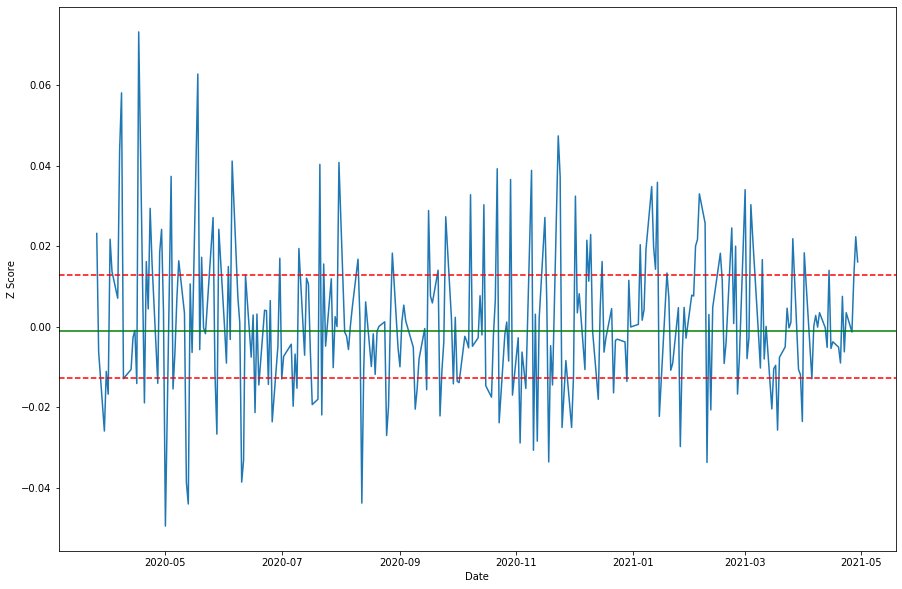

In [17]:
plt.figure(figsize = (15, 10))
plt.plot(daily_z)
plt.axhline(mean, color = 'green')
plt.axhline(std, color = 'red', linestyle = '--')
plt.axhline(-std, color = 'red', linestyle = '--')


plt.xlabel('Date')
plt.ylabel('Z Score')

plt.show()

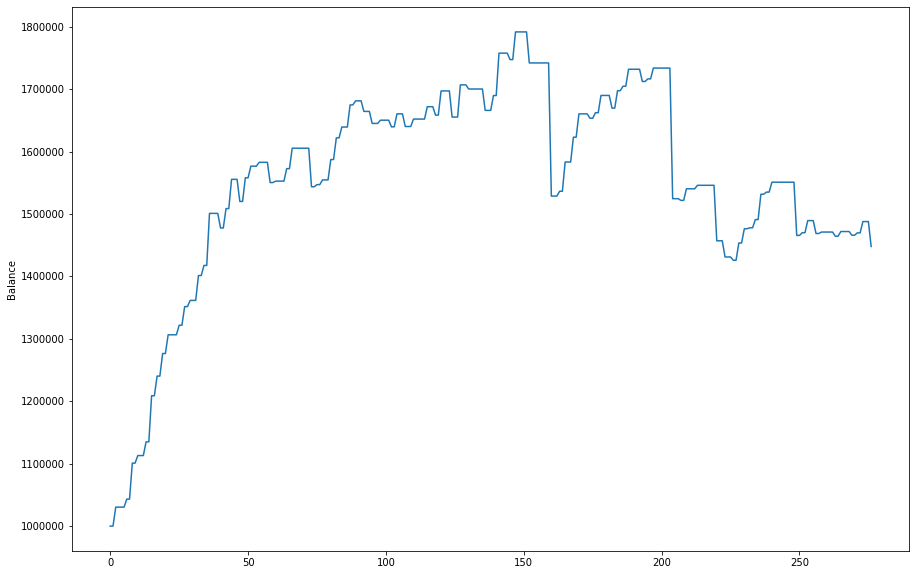

In [19]:
plt.figure(figsize = (15, 10))
plt.plot(balance)
# plt.axhline(mean, color = 'green')
# plt.axhline(std, color = 'red', linestyle = '--')
# plt.axhline(-std, color = 'red', linestyle = '--')


plt.ylabel('Balance')

plt.show()

In [14]:
total_money, rate_return, num_stock1, num_stock2, position, balance = invest_std2(s1,s2,window)

Date: 2020-03-26

long position on E and short position on XOM
Money Balance: 1000000.372138977

Date: 2020-03-27

Hold position

Date: 2020-03-30

Closed position
Money Balance: 1030358.083582434

Date: 2020-03-31

long position on XOM and short position on E
Money Balance: 1030357.130457434

Date: 2020-04-01

Hold position

Date: 2020-04-02

Hold position

Date: 2020-04-03

Closed position
Money Balance: 1043212.4772535725

Date: 2020-04-06

long position on XOM and short position on E
Money Balance: 1043212.2557875081

Date: 2020-04-07

Closed position
Money Balance: 1100868.5265368423

Date: 2020-04-08

long position on E and short position on XOM
Money Balance: 1100868.7382296524

Date: 2020-04-09

Closed position
Money Balance: 1112981.8499237404

Date: 2020-04-13

long position on XOM and short position on E
Money Balance: 1112981.6136108742

Date: 2020-04-14

Hold position

Date: 2020-04-15

Closed position
Money Balance: 1134939.90901704

Date: 2020-04-16

long position on XOM

/Users/hyungtaegoh/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hyungtaegoh/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/hyungtaegoh/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


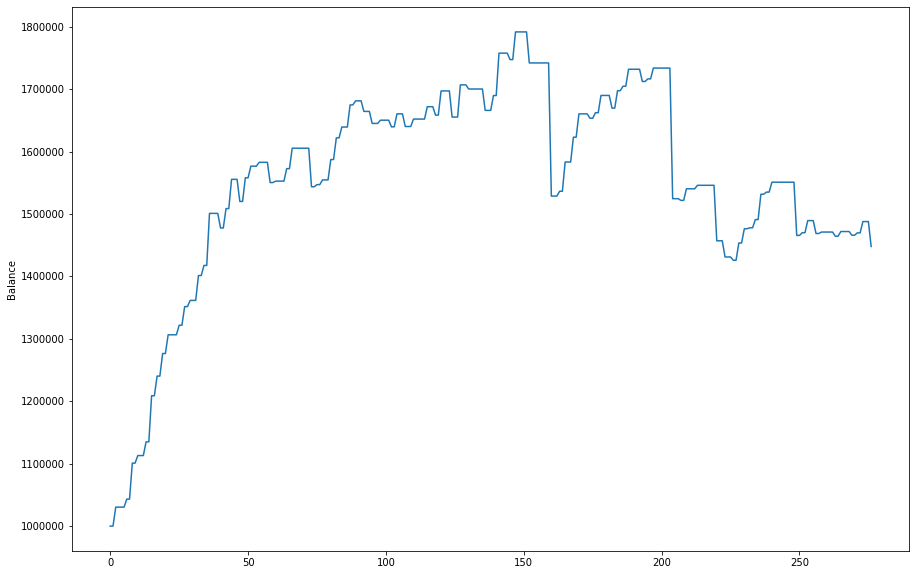

In [15]:
plt.figure(figsize = (15, 10))
plt.plot(balance)
# plt.axhline(mean, color = 'green')
# plt.axhline(std, color = 'red', linestyle = '--')
# plt.axhline(-std, color = 'red', linestyle = '--')


plt.ylabel('Balance')

plt.show()